<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/1g_mlp_tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón multicapa: tarea


<div style="text-align: right"> Bere et Richardt </div>

---



Implementa una red completamente conectada para  la tarea de clasificación de imágenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguiente especificaciones:

* Explora con diferentes número de neuronas, capas,  funciones de activación e hiperparámetros
* Discute tus resultados con las distintas configuraciones.

In [1]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm

# directorio de datos
DATA_DIR = '../data'

# MNIST
MEAN = (0.1307)
STD = (0.3081)

# tamaño del lote
BATCH_SIZE = 128

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

In [4]:
# creamos un Dataset
ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


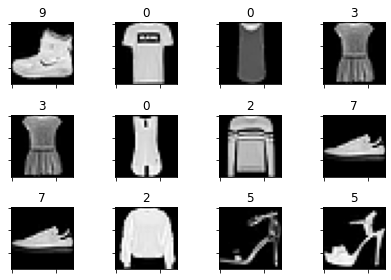

In [5]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(12):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, 3, 4)

In [6]:
# transformaciones para la imagen
trn_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


In [7]:
# transformaciones para la imagen
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
tst_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tst_tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# imprimimos forma y tipo del lote
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


In [8]:
# definición del modelo
class MLP(nn.Module):

    # inicializador
    def __init__(self):
        # inicilización del objeto padre, obligatorio
        super(MLP, self).__init__()
        # tamaño de las capas
        self.I = 1 * 28 * 28
        F1,F2,F3,F4,FF = 1024,1024,2048,2048,10
        # definición de capas
        self.cls = nn.Sequential(
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, F1),
            nn.ReLU(),
            nn.Linear(F1, F2),
            nn.ReLU(),
            nn.Linear(F2, F3),
            nn.ReLU(),
            nn.Linear(F3, F4),
            nn.ReLU(),
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(F4, FF)
        )

    # metodo para inferencia
    def forward(self, x):
        # aplanamos los pixeles de la imagen
        # [N, 1, 28, 28] => [N, 1x28x28]
        x = x.view(-1, self.I)
        # inferencia
        # [N, 1x28x28]
        x = self.cls(x)
        return x

In [9]:
# inferencia con datos sinteticos
model = MLP()
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(y.shape)

torch.Size([1, 10])


In [10]:
# creamos un modelo
model = model
model.to(device)

# optimizador
opt = optim.SGD(model.parameters(), lr=1e-1)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 50
for epoch in range(EPOCHS):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        x,y_true = x.to(device), y_true.to(device)
        # vaciamos los gradientes
        opt.zero_grad()
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad(): 
        # modelo en modo de evaluación
        model.eval()

        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 10):
            x,y_true = x.to(device), y_true.to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)

            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')

        # agregagmos al historial de pérdidas
        loss_hist.append(loss)

        # modelo en modo de entrenamiento
        model.train()

E 0 loss= 41.96 acc=85.31
E 1 loss= 40.83 acc=84.92
E 2 loss= 57.41 acc=80.16
E 3 loss= 39.37 acc=85.86
E 4 loss= 36.45 acc=86.80
E 5 loss= 32.60 acc=88.05
E 6 loss= 39.86 acc=85.62
E 7 loss= 35.59 acc=87.03
E 8 loss= 35.15 acc=88.05
E 9 loss= 35.08 acc=88.28
E10 loss= 30.71 acc=89.06
E11 loss= 30.67 acc=89.38
E12 loss= 34.03 acc=88.59
E13 loss= 31.52 acc=89.38
E14 loss= 37.43 acc=87.81
E15 loss= 30.81 acc=90.08
E16 loss= 36.27 acc=87.50
E17 loss= 32.57 acc=90.23
E18 loss= 35.29 acc=88.59
E19 loss= 43.15 acc=88.12
E20 loss= 30.46 acc=90.47
E21 loss= 33.54 acc=89.84
E22 loss= 38.76 acc=90.16
E23 loss= 45.90 acc=88.52
E24 loss= 32.47 acc=91.41
E25 loss= 40.04 acc=90.08
E26 loss= 38.31 acc=89.61
E27 loss= 32.17 acc=89.92
E28 loss= 47.40 acc=87.58
E29 loss= 33.43 acc=90.31
E30 loss= 48.05 acc=89.14
E31 loss= 55.60 acc=87.34
E32 loss= 49.33 acc=88.67
E33 loss= 37.26 acc=88.75
E34 loss= 38.24 acc=88.75
E35 loss= 47.04 acc=88.20
E36 loss= 46.11 acc=88.05
E37 loss= 41.46 acc=89.84
E38 loss= 43

In [11]:
# numlay = [2,4,8,16,32]
# models = {}
# count = 0
# for numl in numlay:
#     for mods in range(2):
#         count += 1
#         if numl == 2:
#             rand = np.random.randint(64, 512, size = numl)
#             lay=[0 for i in range(len(rand)-1)]
#             for j in range(len(rand)-1):
#                 lay[j] = nn.Linear(rand[j],rand[j+1])
#             class MLP(nn.Module):

#                 # inicializador
#                 def __init__(self):
#                     # inicilización del objeto padre, obligatorio
#                     super(MLP, self).__init__()
#                     # tamaño de las capas
#                     self.I = 1 * 28 * 28
#                     FF = 10
#                     # definición de capas
#                     self.cls = nn.Sequential(
#                         # fc1
#                         # [N, 1x28x28] => [N, 128]
#                         nn.Linear(self.I, rand[0]),
#                         nn.ReLU(),
#                         lay[0],
#                         nn.ReLU(),
#                         # fc2
#                         # [N, 128] => [N, 10]
#                         nn.Linear(rand[-1], FF)
#                     )

#                 # metodo para inferencia
#                 def forward(self, x):
#                     # aplanamos los pixeles de la imagen
#                     # [N, 1, 28, 28] => [N, 1x28x28]
#                     x = x.view(-1, self.I)
#                     # inferencia
#                     # [N, 1x28x28]
#                     x = self.cls(x)
#                     return x
        
# ############################################################################################################################ 
        
#         if numl == 4:
#             rand = np.random.randint(64, 512, size = numl)
#             lay=[0 for i in range(len(rand)-1)]
#             for j in range(len(rand)-1):
#                 lay[j] = nn.Linear(rand[j],rand[j+1])
#             class MLP(nn.Module):

#                 # inicializador
#                 def __init__(self):
#                     # inicilización del objeto padre, obligatorio
#                     super(MLP, self).__init__()
#                     # tamaño de las capas
#                     self.I = 1 * 28 * 28
#                     FF = 10
#                     # definición de capas
#                     self.cls = nn.Sequential(
#                         # fc1
#                         # [N, 1x28x28] => [N, 128]
#                         nn.Linear(self.I, rand[0]),
#                         nn.ReLU(),
#                         lay[0],
#                         nn.ReLU(),
#                         lay[1],
#                         nn.ReLU(),
#                         lay[2],
#                         nn.ReLU(),
#                         # fc2
#                         # [N, 128] => [N, 10]
#                         nn.Linear(rand[-1], FF)
#                     )

#                 # metodo para inferencia
#                 def forward(self, x):
#                     # aplanamos los pixeles de la imagen
#                     # [N, 1, 28, 28] => [N, 1x28x28]
#                     x = x.view(-1, self.I)
#                     # inferencia
#                     # [N, 1x28x28]
#                     x = self.cls(x)
#                     return x
                
# ##########################################################################################################################
#         if numl == 8:
#             rand = np.random.randint(64, 512, size = numl)
#             lay=[0 for i in range(len(rand)-1)]
#             for j in range(len(rand)-1):
#                 lay[j] = nn.Linear(rand[j],rand[j+1])
    
#             class MLP(nn.Module):

#                 # inicializador
#                 def __init__(self):
#                     # inicilización del objeto padre, obligatorio
#                     super(MLP, self).__init__()
#                     # tamaño de las capas
#                     self.I = 1 * 28 * 28
#                     FF = 10
#                     # definición de capas
#                     self.cls = nn.Sequential(
#                         # fc1
#                         # [N, 1x28x28] => [N, 128]
#                         nn.Linear(self.I, rand[0]),
#                         nn.ReLU(),
#                         lay[0],
#                         nn.ReLU(),
#                         lay[1],
#                         nn.ReLU(),
#                         lay[2],
#                         nn.ReLU(),
#                         lay[3],
#                         nn.ReLU(),
#                         lay[4],
#                         nn.ReLU(),
#                         lay[5],
#                         nn.ReLU(),
#                         lay[6],
#                         nn.ReLU(),
#                         # fc2
#                         # [N, 128] => [N, 10]
#                         nn.Linear(rand[-1], FF)
#                     )

#                 # metodo para inferencia
#                 def forward(self, x):
#                     # aplanamos los pixeles de la imagen
#                     # [N, 1, 28, 28] => [N, 1x28x28]
#                     x = x.view(-1, self.I)
#                     # inferencia
#                     # [N, 1x28x28]
#                     x = self.cls(x)
#                     return x
                
# ##########################################################################################################################
#         if numl == 16:
#             rand = np.random.randint(64, 512, size = numl)
#             lay=[0 for i in range(len(rand)-1)]
#             for j in range(len(rand)-1):
#                 lay[j] = nn.Linear(rand[j],rand[j+1])
#             class MLP(nn.Module):

#                 # inicializador
#                 def __init__(self):
#                     # inicilización del objeto padre, obligatorio
#                     super(MLP, self).__init__()
#                     # tamaño de las capas
#                     self.I = 1 * 28 * 28
#                     FF = 10
#                     # definición de capas
#                     self.cls = nn.Sequential(
#                         # fc1
#                         # [N, 1x28x28] => [N, 128]
#                         nn.Linear(self.I, rand[0]),
#                         nn.ReLU(),
#                         lay[0],
#                         nn.ReLU(),
#                         lay[1],
#                         nn.ReLU(),
#                         lay[2],
#                         nn.ReLU(),
#                         lay[3],
#                         nn.ReLU(),
#                         lay[4],
#                         nn.ReLU(),
#                         lay[5],
#                         nn.ReLU(),
#                         lay[6],
#                         nn.ReLU(),
#                         lay[7],
#                         nn.ReLU(),
#                         lay[8],
#                         nn.ReLU(),
#                         lay[9],
#                         nn.ReLU(),
#                         lay[10],
#                         nn.ReLU(),
#                         lay[11],
#                         nn.ReLU(),
#                         lay[12],
#                         nn.ReLU(),
#                         lay[13],
#                         nn.ReLU(),
#                         lay[14],
#                         nn.ReLU(),
#                         # fc2
#                         # [N, 128] => [N, 10]
#                         nn.Linear(rand[-1], FF)
#                     )

#                 # metodo para inferencia
#                 def forward(self, x):
#                     # aplanamos los pixeles de la imagen
#                     # [N, 1, 28, 28] => [N, 1x28x28]
#                     x = x.view(-1, self.I)
#                     # inferencia
#                     # [N, 1x28x28]
#                     x = self.cls(x)
#                     return x
                
# ###########################################################################################################################
#         if numl == 32:
#             rand = np.random.randint(64, 512, size = numl)
#             lay=[0 for i in range(len(rand)-1)]
#             for j in range(len(rand)-1):
#                 lay[j] = nn.Linear(rand[j],rand[j+1])
#             class MLP(nn.Module):

#                 # inicializador
#                 def __init__(self):
#                     # inicilización del objeto padre, obligatorio
#                     super(MLP, self).__init__()
#                     # tamaño de las capas
#                     self.I = 1 * 28 * 28
#                     FF = 10
#                     # definición de capas
#                     self.cls = nn.Sequential(
#                         # fc1
#                         # [N, 1x28x28] => [N, 128]
#                         nn.Linear(self.I, rand[0]),
#                         nn.ReLU(),
#                         lay[0],
#                         nn.ReLU(),
#                         lay[1],
#                         nn.ReLU(),
#                         lay[2],
#                         nn.ReLU(),
#                         lay[3],
#                         nn.ReLU(),
#                         lay[4],
#                         nn.ReLU(),
#                         lay[5],
#                         nn.ReLU(),
#                         lay[6],
#                         nn.ReLU(),
#                         lay[7],
#                         nn.ReLU(),
#                         lay[8],
#                         nn.ReLU(),
#                         lay[9],
#                         nn.ReLU(),
#                         lay[10],
#                         nn.ReLU(),
#                         lay[11],
#                         nn.ReLU(),
#                         lay[12],
#                         nn.ReLU(),
#                         lay[13],
#                         nn.ReLU(),
#                         lay[14],
#                         nn.ReLU(),
#                         lay[15],
#                         nn.ReLU(),
#                         lay[16],
#                         nn.ReLU(),
#                         lay[17],
#                         nn.ReLU(),
#                         lay[18],
#                         nn.ReLU(),
#                         lay[19],
#                         nn.ReLU(),
#                         lay[20],
#                         nn.ReLU(),
#                         lay[21],
#                         nn.ReLU(),
#                         lay[22],
#                         nn.ReLU(),
#                         lay[23],
#                         nn.ReLU(),
#                         lay[24],
#                         nn.ReLU(),
#                         lay[25],
#                         nn.ReLU(),
#                         lay[26],
#                         nn.ReLU(),
#                         lay[27],
#                         nn.ReLU(),
#                         lay[28],
#                         nn.ReLU(),
#                         lay[29],
#                         nn.ReLU(),
#                         lay[30],
#                         nn.ReLU(),
#                         # fc2
#                         # [N, 128] => [N, 10]
#                         nn.Linear(rand[-1], FF)
#                     )

#                 # metodo para inferencia
#                 def forward(self, x):
#                     # aplanamos los pixeles de la imagen
#                     # [N, 1, 28, 28] => [N, 1x28x28]
#                     x = x.view(-1, self.I)
#                     # inferencia
#                     # [N, 1x28x28]
#                     x = self.cls(x)
#                     return x
#         models['model{}'.format(count)] = MLP()

In [12]:
# models

In [13]:
# for ms in models.keys():
#     print('\n',ms)
#     model = models[ms]
#     # inferencia con datos sinteticos
#     x = torch.zeros(1, 1, 28, 28)
#     y = model(x)
#     print(y.shape)

In [14]:
# for ms in models.keys():
#     model = models[ms]
#     # creamos un modelo
#     model = MLP()
#     model.to(device)

#     # optimizador
#     opt = optim.SGD(model.parameters(), lr=1e-3)
#     # historial de pérdida
#     loss_hist = []

#     # ciclo de entrenamiento
#     EPOCHS = 20
#     for epoch in range(EPOCHS):

#         # entrenamiento de una época
#         for x, y_true in trn_dl:
#             x,y_true = x.to(device), y_true.to(device)
#             # vaciamos los gradientes
#             opt.zero_grad()
#             # hacemos inferencia para obtener los logits
#             y_lgts = model(x)
#             # calculamos la pérdida
#             loss = F.cross_entropy(y_lgts, y_true)
#             # retropropagamos
#             loss.backward()
#             # actulizamos parámetros
#             opt.step()

#         # evitamos que se registren las operaciones 
#         # en la gráfica de cómputo
#         with torch.no_grad(): 
#             # modelo en modo de evaluación
#             model.eval()

#             losses, accs = [], []
#             # validación de la época
#             for x, y_true in take(tst_dl, 10):
#                 x,y_true = x.to(device), y_true.to(device)
#                 # hacemos inferencia para obtener los logits
#                 y_lgts = model(x)
#                 # calculamos las probabilidades
#                 y_prob = F.softmax(y_lgts, 1)
#                 # obtenemos la clase predicha
#                 y_pred = torch.argmax(y_prob, 1)

#                 # calculamos la pérdida
#                 loss = F.cross_entropy(y_lgts, y_true)
#                 # calculamos la exactitud
#                 acc = (y_true == y_pred).type(torch.float32).mean()

#                 # guardamos históricos
#                 losses.append(loss.item() * 100)
#                 accs.append(acc.item() * 100)

#             # imprimimos métricas
#             loss = np.mean(losses)
#             acc = np.mean(accs)
#             print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')

#             # agregagmos al historial de pérdidas
#             loss_hist.append(loss)

#             # modelo en modo de entrenamiento
#             model.train()

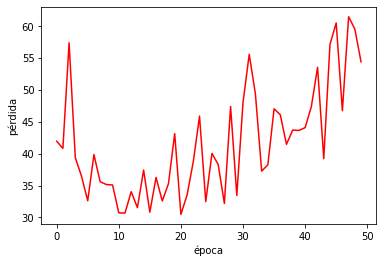

In [15]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

In [16]:
# modelo en modo de evaluación
model.eval()

# evitamos que se registren las operaciones 
# en la gráfica de cómputo
with torch.no_grad(): 
        
    accs = []
    # validación de la época
    for x, y_true in tst_dl:
        x,y_true = x.to(device), y_true.to(device)
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos las probabilidades
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)
        
        # calculamos la exactitud
        x, y_true, y_pred = x.cpu(),y_true.cpu(),y_pred.cpu()
        acc = (y_true == y_pred).type(torch.float32).mean()

        accs.append(acc.item() * 100)

    acc = np.mean(accs)

print(f'Exactitud = {acc:.2f}')

Exactitud = 89.56


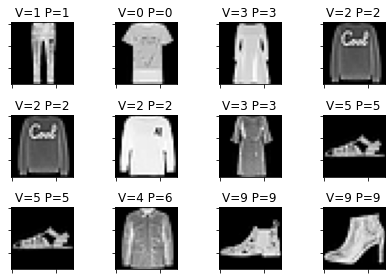

In [17]:
with torch.no_grad(): 
    for x, y_true in take(tst_dl, 1):
        x,y_true = x.to(device), y_true.to(device)
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)
        
    x, y_true, y_pred = x.cpu(),y_true.cpu(),y_pred.cpu()
    x = x[:12].squeeze().numpy()
    y_true = y_true[:12].numpy()
    y_pred = y_pred[:12].numpy()

titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
display_grid(x, titles, 3, 4)

## Discusión de Resultados

Hasta ahora el mejor accuracy en el conjunto de pureba ha sido 89.5. Priemro probe creando diferentes arquitecturas con número de capas de [2,4,8,16,32] y con número de neuronas por capa seleccionado de forma aleatoria entre 64 y 512, sin embargo, esto no resulto efectivo, ya que despues de un uso de arquitectura que contenga mas de 5 capas ocultas la eficacia decae drasticamente y el modelo solo acierta en las probalisticamente acertaria si todo se hiciese al azar, es decir $10%$ ya que solo tenemos $10$ clases. Despues se intento con una cantidad fija de 4 capas ocultas, y con numero de neuroans por capa definido, en una potencia de 2, pero variando el learning rate, con esto priemro lo varie para que fuera mas chico, y en algunos casos cuando habia numero de neuronas aleatorio lograba alcanzar $80\%$ de eficacia en validación pero no era repetible. Posteriormente movi el learningrate para que fuera mas grande sin llegar a serlo demasiado y es cuando se obtuvieron lo mejores resultados por mi parte hasta ahora alcanzando un $92\%$ de eficacia en validación y $89\%$ en eficacia